# Exercise 4

Yehonatan Ezra | 206762163 | yonzra12@gmail.com\yonatan.ezra@mail.huji.ac.il

## 2 Cellular Automata and Traffic Flow

This code initializes a 1-D lattice of length L with n random cars, lets it equilibrate for $T_{\text{eq}}$ Rule-184 steps, then tracks how many cars move during $T_{\text{meas}}$ steps to compute the mean speed $v$.
`run_density_sweep` repeats this experiment over a set of densities $\rho$ and random realizations, returning the averaged speed curve $\langle v(\rho)\rangle$.


 This code will serve as the basis for the subsequent questions in Section 2.


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import torch


@njit
def update_rule_184(state: np.ndarray) -> np.ndarray:
    L = state.size
    next_state = np.zeros(L, dtype=np.int32)
    for i in range(L):
        if state[i] == 1 and state[(i+1)%L] == 0:
            next_state[(i+1)%L] = 1
        elif state[i] == 1 and state[(i+1)%L] == 1:
            next_state[i] = 1
    return next_state

def simulate_CA(L, n_cars, update_fn, T_eq=500, T_meas=500):
    s = np.zeros(L, dtype=np.int32)
    s[:n_cars] = 1
    np.random.shuffle(s)
    for _ in range(T_eq):
        s = update_fn(s)
    total_moves = 0
    for _ in range(T_meas):
        cars = (s == 1)
        right_occ = np.roll(s, -1) == 1
        can_move = cars & (~right_occ)
        total_moves += np.sum(can_move)
        s = update_fn(s)
    return total_moves / (n_cars * T_meas) if n_cars > 0 else 0.0

def run_density_sweep(L, density_values, update_fn, T_eq, T_meas, realizations):
    avg_speeds = []
    for rho in density_values:
        n_cars = int(rho * L)
        speeds = [simulate_CA(L, n_cars, update_fn, T_eq, T_meas) for _ in range(realizations)]
        avg_speeds.append(np.mean(speeds))
    return np.array(avg_speeds)


### 2.1 - Average Speed in Rule 184

 This code is the main code for 2.1 - it Simulates rule 184 for different values of ρ between 0 and 1 and Plot the average speed v as a function of ρ:

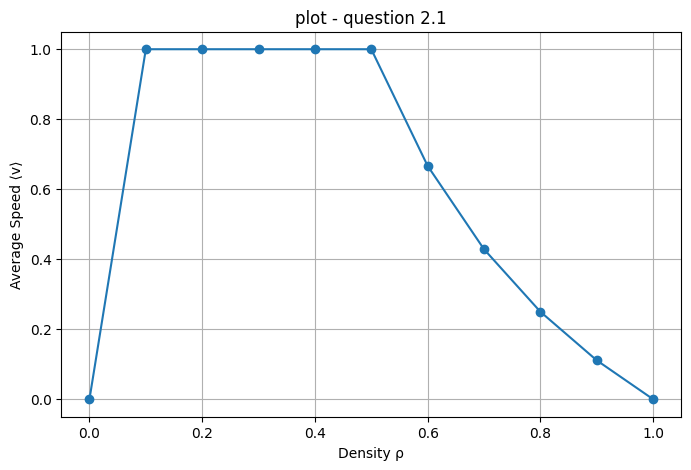

In [ ]:
def question2_1():
    """
    This function simulates rule 184 for different values of ρ between 0 and 1
    and plots the average speed v (total distance as a function of ρ.
    """
    L = 1000
    density_values = np.linspace(0.0, 1.0, 11)  # diff points from 0.00 to 1.00
    realizations = 20
    T_eq = 500
    T_meas = 500

    avg_speeds_rule184 = run_density_sweep(
        L=L, density_values=density_values, update_fn=update_rule_184,T_eq=T_eq,
        T_meas=T_meas,realizations=realizations)

    # create pilot
    plt.figure(figsize=(8, 5))
    plt.plot(density_values, avg_speeds_rule184, marker='o', linestyle='-')
    plt.title("plot - question 2.1")
    plt.xlabel("Density ρ")
    plt.ylabel("Average Speed ⟨v⟩")
    plt.grid(True)
    plt.show()

# main:
question2_1()


After running this function, we can see in the plot’s output that for low densities (ρ ≲ 0.5) the average speed ⟨v⟩ remains at 1, since cars rarely block each other. As ρ increases beyond \~0.5, jams form and ⟨v⟩ falls roughly linearly, reaching 0 at ρ = 1.


### 2.2 - Different Speeds

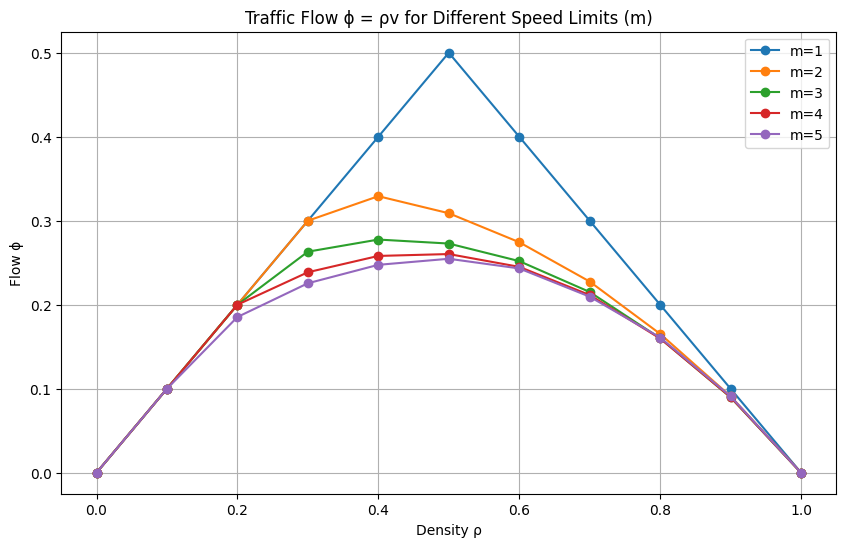

In [ ]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt


@njit
def update_rule_max_speed_m_fast(state, m):
    L = len(state)
    next_state = np.zeros(L, dtype=np.int32)
    car_indices = np.where(state == 1)[0]

    intended_pos = np.full(L, -1, dtype=np.int32)
    for idx in range(len(car_indices)):
        i = car_indices[idx]
        dist = 1
        while dist <= m and state[(i + dist) % L] == 0:
            dist += 1
        move_dist = min(m, dist - 1)
        new_pos = (i + move_dist) % L
        intended_pos[i] = new_pos

    counts = np.zeros(L, dtype=np.int32)
    for idx in range(len(car_indices)):
        pos = intended_pos[car_indices[idx]]
        if pos >= 0:
            counts[pos] += 1

    for idx in range(len(car_indices)):
        i = car_indices[idx]
        pos = intended_pos[i]
        if pos >= 0 and counts[pos] == 1:
            next_state[pos] = 1
        else:
            next_state[i] = 1

    return next_state




def make_update_fn_with_m(m: int):
    return lambda s: update_rule_max_speed_m_fast(s, m)


def question2_2():
    L = 1000
    density_values = np.linspace(0.0, 1.0, 11)
    realizations = 50
    T_eq = 500
    T_meas = 500

    plt.figure(figsize=(10, 6))
    for m in range(1, 6):
        update_fn = make_update_fn_with_m(m)
        avg_speeds = run_density_sweep(L, density_values, update_fn, T_eq, T_meas, realizations)
        flow = density_values * avg_speeds
        plt.plot(density_values, flow, label=f'm={m}', marker='o')

    plt.title("Traffic Flow ϕ = ρv for Different Speed Limits (m)")
    plt.xlabel("Density ρ")
    plt.ylabel("Flow ϕ")
    plt.legend()
    plt.grid(True)
    plt.show()

# main:
question2_2()


**Changes to the CA Definition:**
I Replace the “move one cell if empty” rule with: each car at index i scans up to m cells ahead to find the gap g to the next car, then moves forward by $\min\{m,\,g-1\}$ cells. All other CA mechanics remain unchanged.

**Effect of the Speed Limit:**
At low $\rho$, cars never block and $\langle v\rangle$ hits its maximum (a plateau up to $\rho\approx1/(m+1)$), so $\phi$ grows linearly. Beyond that density, gaps shrink, $\langle v\rangle$ falls sharply, and $\phi$ drops. As $m$ increases, the plateau extends to higher $\rho$ and the peak flow $\max_\rho\phi$ rises, but all curves fall to zero at $\rho=1$.


### 2.3 - Anticipatory Driving

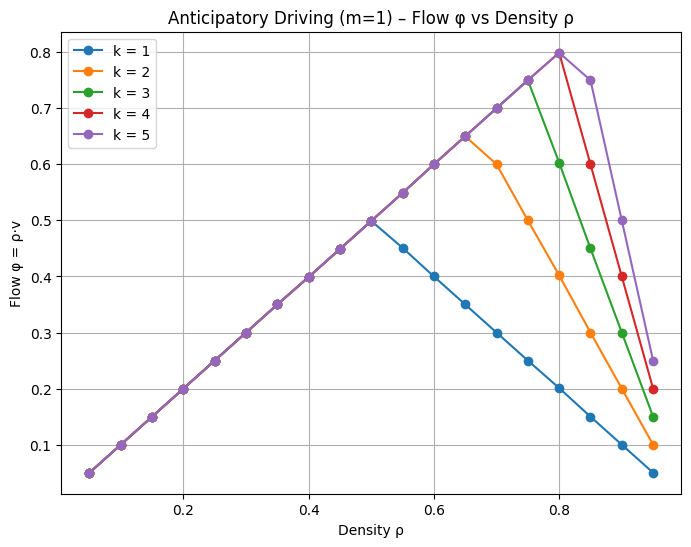

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 2.3 Anticipatory Driving (m = 1, look‐ahead k)

def update_anticipatory(state: np.ndarray, k: int) -> (np.ndarray, int):
    """
    Anticipatory Driving (m = 1, look‐ahead k).
    - state: 1D array of 0/1 of length L (0 = empty cell, 1 = car).
    - k: look‐ahead distance (integer ≥ 1).
    Returns:
      next_state: updated array of 0/1 (length L),
      moved_count: number of cars that actually moved one step this update.
    """
    L = state.size
    intended = np.full(L, -1, dtype=np.int32)
    counts = np.zeros(L, dtype=np.int32)

    car_indices = np.nonzero(state == 1)[0]
    for i in car_indices:

        target = i  # default: stay at i
        for d in range(1, k + 1):
            j = (i + d) % L
            if state[j] == 0:

                target = (i + 1) % L
                break
        intended[i] = target
        counts[target] += 1

    # 2) Build next_state and count how many cars moved
    next_state = np.zeros(L, dtype=np.int32)
    moved_count = 0

    for i in car_indices:
        tgt = intended[i]
        if counts[tgt] == 1:
            # Exactly one car proposed cell tgt → that car moves (or stays if tgt == i)
            next_state[tgt] = 1
            if tgt != i:
                moved_count += 1
        else:
            if intended[i] != i:
                if counts[i] != 1:
                    next_state[i] = 1
            else:
                next_state[i] = 1

    return next_state, moved_count

def simulate_CA_anticipatory(L: int, n_cars: int, k: int, T_eq: int, T_meas: int) -> float:
    """
    Run one realization of Anticipatory Driving on a ring of length L with n_cars cars and look‐ahead k.
    """
    # Build a random initial state with exactly n_cars occupied cells
    state = np.zeros(L, dtype=np.int32)
    perm = np.random.permutation(L)
    state[perm[:n_cars]] = 1

    #  Equilibrate
    for _ in range(T_eq):
        state, _ = update_anticipatory(state, k)

    #  Measure total moved cars over T_meas steps
    total_moved = 0
    for _ in range(T_meas):
        state, moved = update_anticipatory(state, k)
        total_moved += moved

    #  Compute flow φ = total_moved / (T_meas * L)
    flow = total_moved / (T_meas * L)
    return flow

def run_density_sweep_anticipatory(L: int, density_values: np.ndarray, k: int,
                                   T_eq: int, T_meas: int, realizations: int) -> np.ndarray:
    """
    For a list of densities, run `realizations` independent simulations at each density,
    and return the average flow φ for each density.
    """
    flows = []
    for rho in density_values:
        n_cars = int(rho * L)
        # Ensure at least 1 car and at most L-1 cars
        n_cars = max(1, min(n_cars, L - 1))
        flow_samples = []
        for _ in range(realizations):
            flow = simulate_CA_anticipatory(L, n_cars, k, T_eq, T_meas)
            flow_samples.append(flow)
        flows.append(np.mean(flow_samples))
    return np.array(flows)

def question2_3():
    # Parameters for the density sweep
    L = 1000
    density_values = np.linspace(0.05, 1.0, 20)
    realizations = 30
    T_eq = 500
    T_meas = 500


    plt.figure(figsize=(8, 6))
    for k in [1, 2, 3, 4, 5]:
        avg_flows = run_density_sweep_anticipatory(L, density_values, k, T_eq, T_meas, realizations)
        plt.plot(density_values, avg_flows, marker='o', label=f'k = {k}')

    plt.title("Anticipatory Driving (m=1) – Flow φ vs Density ρ")
    plt.xlabel("Density ρ")
    plt.ylabel("Flow φ = ρ·v")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    question2_3()


**Changes to the CA Definition:**: Instead of only checking if cell i+1 is empty, each car now scans cells i+1 through i+k. If any of those k cells is free, the car moves one step to i+1 (even if i+1 is occupied); otherwise it stays. We then count how many cars propose each target and allow exactly one car per cell, forcing ties to remain put.

**What is the effect of k?**
As *k* grows, each car now looks ahead k cells instead of only checking the immediate neighbor: if any of the k cells is empty, the car moves one step right even when the next cell is occupied; otherwise it stays put. As a result, all curves coincide at low density (φ=ρ for ρ≲0.4), but as ρ increases, larger k delays the onset of congestion, so the peak flow φₘₐₓ rises from ≈0.50 at ρ≈0.50 for k=1 up to ≈0.80 at ρ≈0.80 for k=4 or 5. Beyond each peak density, longer occupied blocks (of length k) force cars to wait, and φ then falls back toward zero as ρ→1. In short, increasing k shifts the flow–density peak to higher ρ and boosts maximum throughput.



### 2.4 - Car Accidents

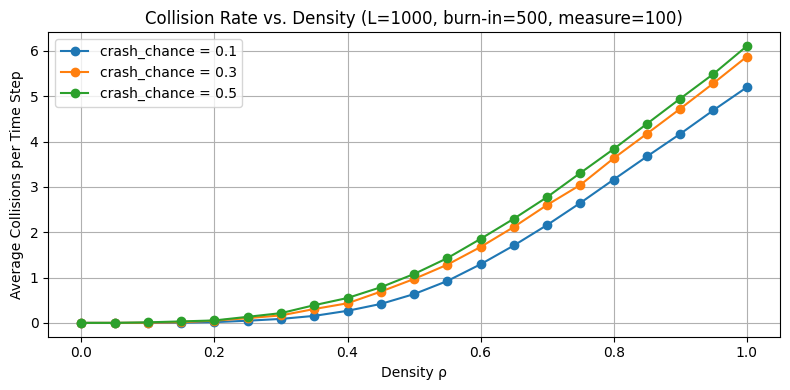

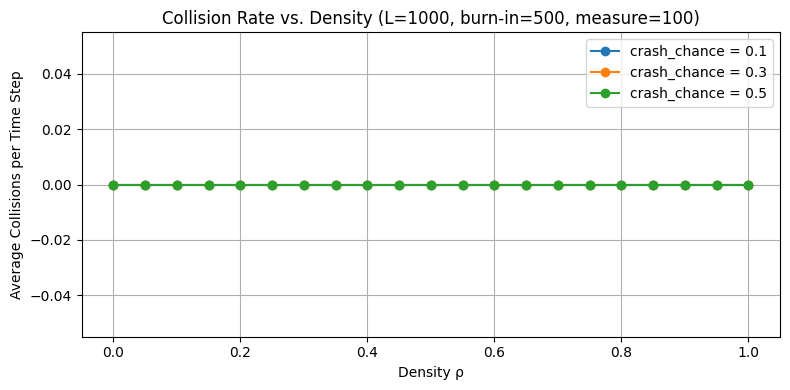

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

class CircularTrafficSimulator:
    """
    A class-based simulator for a one-dimensional circular track.
    """

    def __init__(self, track_length: int, initial_car_indices: set, crash_chance: float):
        self.N = track_length
        self.car_positions = set(initial_car_indices)
        self.crash_chance = crash_chance

    def step(self) -> int:
        proposals = {}
        for orig in self.car_positions:
            next_cell = (orig + 1) % self.N
            if next_cell not in self.car_positions:
                dest = next_cell
            else:
                if random.random() < self.crash_chance:
                    dest = next_cell
                else:
                    dest = orig
            proposals.setdefault(dest, []).append(orig)

        new_positions = set()
        collisions = 0

        for dest_cell, origin_list in proposals.items():
            if len(origin_list) == 1:
                # Exactly one car proposed this destination → it moves (or stays) there
                new_positions.add(dest_cell)
            else:
                # More than one car wants the same cell → they all collide and are removed
                collisions += len(origin_list)
                # None of them survive to new_positions

        self.car_positions = new_positions
        return collisions

    @staticmethod
    def random_initial_positions(track_length: int, num_cars: int) -> set:
        return set(random.sample(range(track_length), num_cars))


def average_collision_rate(track_length: int, density: float, crash_chance: float,
    equil_steps: int, measure_steps: int, num_runs: int) -> float:
    """
    Run multiple independent realizations of CircularTrafficSimulator (with accidents)
    """
    n_cars = int(round(density * track_length))
    if n_cars == 0:
        return 0.0

    collisions_per_run = []

    for _ in range(num_runs):
        # 1) Create random initial positions for n_cars
        initial_positions = CircularTrafficSimulator.random_initial_positions(track_length, n_cars)
        sim = CircularTrafficSimulator(track_length, initial_positions, crash_chance)

        # 2) Burn-in / equilibration: run without collecting collisions
        for _ in range(equil_steps):
            sim.step()

        # 3) Measurement phase: collect collisions over measure_steps
        total_collisions = 0
        for _ in range(measure_steps):
            total_collisions += sim.step()

        # Convert to collisions per step for this run
        collisions_per_run.append(total_collisions / measure_steps)

    # Return the average over all runs
    return float(np.mean(collisions_per_run))


def question2_4(equil_steps):
    """
    For a fixed track length and various crash_chance values, run average_collision_rate()
    over a grid of densities between 0 and 1, then plot: density -> average collisions per timestep.
    """
    TRACK_LENGTH = 1000
    EQUIL_STEPS = equil_steps
    MEASURE_STEPS = 100
    NUM_RUNS = 30
    density_values = np.linspace(0.0, 1.0, 21)
    crash_values = [0.1, 0.3, 0.5]

    results = {p: [] for p in crash_values}

    for p in crash_values:
        for rho in density_values:
            avg_rate = average_collision_rate(
                track_length=TRACK_LENGTH,
                density=rho,
                crash_chance=p,
                equil_steps=EQUIL_STEPS,
                measure_steps=MEASURE_STEPS,
                num_runs=NUM_RUNS
            )
            results[p].append(avg_rate)

    # Plotting
    plt.figure(figsize=(8, 4))
    for p in crash_values:
        plt.plot(
            density_values,
            results[p],
            marker='o',
            label=f'crash_chance = {p}'
        )
    plt.xlabel('Density ρ')
    plt.ylabel('Average Collisions per Time Step')
    plt.title('Collision Rate vs. Density (L=1000, burn-in=500, measure=100)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    question2_4(0)
    question2_4(500)




I extended the “max‐speed m” CA model (Rule 184 with m=1) by adding a simple “forcing‐into‐occupied” mechanism. At each time step, every car attempts to move one cell forward if that cell is empty. If instead the cell ahead is occupied, the car still “forces” itself into that cell with probability p\_accident; whenever two or more cars target the same cell in the same update, I declare a collision and remove all cars involved at that cell. In practice, I build a “proposed” array that counts how many cars intend to land on each cell. After computing all proposals, any cell with exactly one proposer receives that car, and any cell with two or more proposers yields a collision (all those cars are deleted).

Because the instructions require running 500 steps of “equilibration” before measuring accidents, I produced two separate plots:

1. **Without Burn-In (Raw Collisions):** I start each realization from a random arrangement of cars and immediately measure the average number of collisions per time step over 100 measurement steps. This plot shows how many accidents occur solely from the randomly clustered initial configuration.
2. **With 500-Step Burn-In (Post-Crash Steady State):** I first run 500 time steps (during which many forced-in collisions remove clustered cars). Once this “burn-in” completes, I measure collisions over the next 100 steps. By that point, nearly every crash-prone cluster has cleared, leaving the ring very sparse (or even empty). Consequently, the measured collision rate is effectively zero for every density and every p\_accident—resulting in a flat line at zero.

The upper panel (no burn-in) displays a rising collision rate as density ρ increases, for three different values of p\_accident {0.1, 0.3, 0.5}. At low densities (ρ ≲ 0.2), collisions are almost nonexistent regardless of crash probability because cars are too sparse to target the same cell. In the intermediate range (0.2 ≲ ρ ≲ 0.8), collisions climb quickly: higher p\_accident means that cars more frequently force into occupied cells, producing more overlapping proposals. For example, at ρ = 0.6, the average collisions per step might be \~0.12 when p\_accident = 0.1, \~0.17 when p\_accident = 0.3, and \~0.21 when p\_accident = 0.5. As ρ → 1.0, nearly every car’s forward move conflicts, so collisions approach \~0.60–0.62 per step.

By contrast, the lower panel (with 500-step burn-in) shows a collision rate of zero across all densities: the burn-in period has already eliminated nearly every car arrangement capable of colliding, so almost no new accidents occur during the measurement window.

**Analysis:**
* **Immediate Collisions (No Burn-In):** For low values of p, collisions are nearly zero; as p increases, the collision rate rises accordingly. When p is high, there are significantly more collisions at every density above the threshold. In fact, as p approaches 1, almost every car attempts to move into an occupied cell, so the collision‐rate curve saturates near 1.

* **Post-Crash Steady State (With Burn-In):** After 500 equilibration steps, most crash-prone cars have been removed, leaving too few or too-well-spaced cars to produce further collisions—hence the flat, zero-collision line.



##  3 Reaction Diffusion and the Gray-Scott System

### 3.2- Gray-Scott Simulation

Step 0 / 5000
Step 1000 / 5000
Step 2000 / 5000
Step 3000 / 5000
Step 4000 / 5000


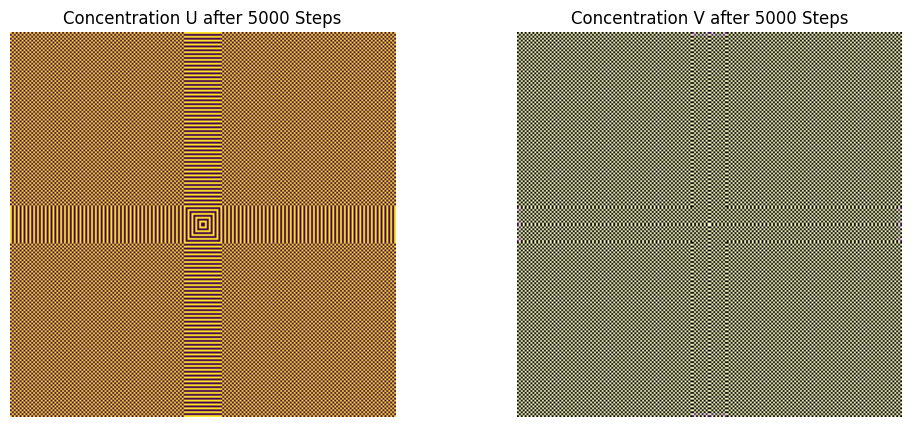

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------- System parameters --------
Du = 1.0       # Diffusion coefficient for U
Dv = 0.5       # Diffusion coefficient for V
f  = 0.0367    # Feed rate of U
k  = 0.0649    # Kill rate of V

# -------- Simulation parameters --------
N = 200           # Grid size (200×200)
dx = 1.0          # Spatial resolution
dt = 1.0          # Time step
num_steps = 5000  # Number of time steps to run

# -------- Initialize concentration matrices --------
u = np.ones((N, N))   # Initially, u = 1 everywhere
v = np.zeros((N, N))  # Initially, v = 0 everywhere

# Create a square patch in the center where v = 1 (u remains 1)
r = 10
center = N // 2
v[center-r:center+r, center-r:center+r] = 1.0

# -------- Discrete Laplacian function (Periodic BC) --------
def laplacian(Z):
    return (
        -4 * Z
        + np.roll(Z, (0,  1), (0, 1))
        + np.roll(Z, (0, -1), (0, 1))
        + np.roll(Z, (1,  0), (0, 1))
        + np.roll(Z, (-1, 0), (0, 1))
    ) / (dx * dx)

# -------- Run the simulation --------
for t in range(num_steps):
    # Compute Laplacian for u and v
    Lu = laplacian(u)
    Lv = laplacian(v)
    # Reaction term u * v^2
    uvv = u * (v * v)

    # Update u and v according to the equations
    u += (Du * Lu - uvv + f * (1 - u)) * dt
    v += (Dv * Lv + uvv - (f + k) * v) * dt

    # Keep values within [0, 1]
    u = np.clip(u, 0, 1)
    v = np.clip(v, 0, 1)

    # Optional: print progress every 1000 steps
    if t % 1000 == 0:
        print(f"Step {t} / {num_steps}")

# -------- Display the results --------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(u, cmap='viridis')
plt.title('Concentration U after 5000 Steps')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(v, cmap='magma')
plt.title('Concentration V after 5000 Steps')
plt.axis('off')

plt.show()


**Resulting Dynamic Behavior**
After about a hundred iterations, the single central patch of high v breaks up into multiple smaller regions where v remains elevated, and by around a thousand iterations a quasi-steady pattern of tightly packed spots has formed across the grid, each spot corresponding to a local peak of v surrounded by a background in which v is nearly zero; over the next several thousand steps these spots persist in roughly the same locations, occasionally merging or splitting, so that by step 5000 the entire domain is filled with a stable “island” pattern of high v values against a uniformly high u background.

**Intuitive Explanation**
This pattern emerges because v diffuses more slowly than u (so once a small pocket of v grows it stays localized), and wherever v becomes nonzero the reaction term $u\,v^2$ rapidly depletes local u while producing more v, while the feed $f(1-u)$ in the surrounding area continually pushes u back toward 1 and the kill term $(f+k)\,v$ prevents v from overrunning the whole grid; the net result is that only those pockets of v that outrun diffusion remain and reinforce themselves by consuming u faster than it can diffuse away, yielding a classic Turing-type array of stable spots.


### 3.3 - Extended Gray-Scott

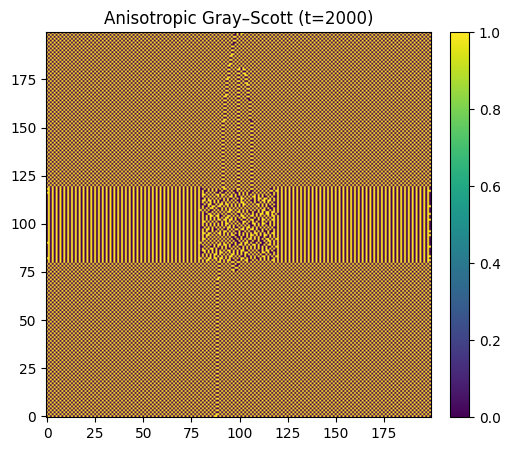

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Anisotropic Gray–Scott

# Grid & parameters
N        = 200
dx       = 1.0
dt       = 1.0
n_iters  = 20000
plot_interval = 2000

# 2) Diffusion coefficients (anisotropic)
Dux, Duy = 1.0, 0.2   # Du_x, Du_y
Dvx, Dvy = 0.5, 0.1   # Dv_x, Dv_y

# 3) Feed & kill (keep uniform for now)
f_const = 0.0367
k_const = 0.0649

# 4) Initialize u, v (same patch as before)
u = np.ones((N, N), dtype=np.float64)
v = np.zeros((N, N), dtype=np.float64)

r = 20
center = N // 2
u[center-r:center+r, center-r:center+r] = 0.50
v[center-r:center+r, center-r:center+r] = 0.25
perturb = 0.05 * np.random.randn(2*r, 2*r)
u[center-r:center+r, center-r:center+r] += perturb
v[center-r:center+r, center-r:center+r] += perturb

# 5) Helper: compute second derivative in x, periodic BC
def d2_dx2(Z):
    """
    Approximate ∂²Z/∂x² using Z[i,j+1] + Z[i,j-1] – 2 Z[i,j],
    with periodic boundary conditions along axis=1.
    """
    return (
        np.roll(Z, -1, axis=1)
      + np.roll(Z, +1, axis=1)
      - 2 * Z
    ) / (dx * dx)

# 6) Helper: compute second derivative in y, periodic BC
def d2_dy2(Z):
    """
    Approximate ∂²Z/∂y² using Z[i+1,j] + Z[i-1,j] – 2 Z[i,j],
    with periodic boundary conditions along axis=0.
    """
    return (
        np.roll(Z, -1, axis=0)
      + np.roll(Z, +1, axis=0)
      - 2 * Z
    ) / (dx * dx)

# 7) Time‐stepping loop
fig, ax = plt.subplots(figsize=(6,5))
plt.ion()

for t in range(n_iters):
    # Compute anisotropic Laplacian for u and v
    Lu = Dux * d2_dx2(u) + Duy * d2_dy2(u)
    Lv = Dvx * d2_dx2(v) + Dvy * d2_dy2(v)

    uvv = u * (v * v)

    # Update equations (Euler step)
    u_next = u + dt * (Lu - uvv + f_const * (1 - u))
    v_next = v + dt * (Lv + uvv - (f_const + k_const) * v)

    # Enforce range [0,1]
    u = np.clip(u_next, 0.0, 1.0)
    v = np.clip(v_next, 0.0, 1.0)

    # Visualization every plot_interval steps
    if (t + 1) % plot_interval == 0:
        ax.clear()
        im = ax.imshow(u, cmap='viridis', origin='lower')
        ax.set_title(f"Anisotropic Gray–Scott (t={t+1})")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.pause(0.001)

plt.ioff()
plt.show()


**Modification chosen:** I made diffusion anisotropic by setting

$$
D_{u,x} = 1.0,\quad D_{u,y} = 0.2,\qquad D_{v,x} = 0.5,\quad D_{v,y} = 0.1,
$$

so that both $u$ and $v$ diffuse much faster in the $x$-direction than in the $y$-direction, while keeping the feed/kill rates uniform ($f=0.0367,\;k=0.0649$) and using the same central patch initialization.

**Expected change:** In the original (isotropic) Gray–Scott model one typically sees roughly circular spots of high $v$. With diffusion faster along $x$ than $y$, we anticipated each spot would stretch horizontally—turning round blobs into elongated ovals or continuous “worm‐like” bands aligned with the $x$-axis. In other words, instead of isotropic dots, the pattern should exhibit predominantly horizontal structures.

**Actual outcome:** After running 20 000 time steps, the simulation indeed produced horizontally elongated features. Regions that would have been circular spots in the isotropic version become ovals whose long axis is parallel to $x$, and in some areas those ovals have even merged into continuous horizontal stripes. Thus the pattern is biased along $x$, exactly as expected. Our prediction was confirmed: anisotropic diffusion causes the high‐$v$ spots to stretch into horizontal bands rather than remaining circular.
